In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import quandl
import quandl as q
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
quandl.ApiConfig.api_key = "-qMZRw2S5XascrrTLjF4"

In [3]:
#pega os dados da API
#msft_data = q.get("EOD/MSFT", start_date="2010-01-01", end_date="2020-01-01")
msft_data = quandl.get("EIA/PET_RWTC_D", start_date="2010-01-01", end_date="2020-01-01")
msft_data.head()

,Value
Date,
2010-01-04,81.52
2010-01-05,81.74
2010-01-06,83.12
2010-01-07,82.60
2010-01-08,82.74


In [5]:
# chama `Adj Close` para `daily_close`
daily_close = msft_data[['Value']]

In [6]:
def getlinear_coefi(x,y):
    
    m = (len(x) * np.sum(x*y) - np.sum(x) * np.sum(y)) / (len(x)*np.sum(x*x) - np.sum(x) * np.sum(x))
    return m

def train_model_and_forecast(train, test):
    step_model = auto_arima(train, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m = 365, start_P = 0,
                       seasonal = False, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings = True,
                       stepwise = False)

    step_model.fit(train)

    future_forecast = step_model.predict(n_periods = len(test))

    future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Return'])
    
    y = []
    x = []
    
    forecast_n = future_forecast.values[0]
    daily_n_1 = train.values[len(train)-1]
    
    for el in future_forecast.values:
        x.append(float(el))
    for i in range(len(future_forecast.values)):
        y.append(i)
        
    return [x,y,forecast_n,daily_n_1]

In [13]:
compra_oportunidade = []
venda_defesa = []
venda_ganho_fixado = []
operacoes = []
status_op = {}
num_op = 0

percentual_ganho = 8
dif_compra = percentual_ganho/100

dias_anteriores_mid = 15
dias_forecast_mid = 15
dias_forecast = 5
dias_treino_antes = 5


m_n_1 = 1
index_ultima_compra_oportunidade_n_1 = -1
forecast_n = 1
forecast_n_1 = 1
daily_n_1 = 1


for k in range(30,len(daily_close)):
    train = daily_close[k-dias_treino_antes:k-1]
    test = daily_close[k:k+dias_forecast]
    
    resultado_modelo = train_model_and_forecast(train, test)
    m = getlinear_coefi(np.array(resultado_modelo[0]),np.array(resultado_modelo[1]))
    m_n = m
    forecast_n = resultado_modelo[2]
    daily_n_1 = resultado_modelo[3]
    
    #OPORTUNIDADE DE COMPRA, pq acha que vai crescer abrupto
    if m_n > 25:
        
        resultado_modelo_mid = train_model_and_forecast(daily_close[k-dias_anteriores_mid:k-1], daily_close[k:k+dias_forecast_mid])
        m_mid = getlinear_coefi(np.array(resultado_modelo_mid[0]),np.array(resultado_modelo_mid[1]))
        if m_mid > 5:
            print('compra:')
            compra_oportunidade.append(k)
            
            num_op = num_op + 1
            status_op['venda'] = 0.1
            status_op['compra'] = k
            status_op['index'] = num_op
  
            
    #VENDA DE DEFESA, vê que o bicho vai cair bruscamente e ja tava caindo nas ultimas semanas
    if m_n < -25:
        resultado_modelo_mid = train_model_and_forecast(daily_close[k-dias_anteriores_mid:k-1], daily_close[k:k+dias_forecast_mid])
        m_mid = getlinear_coefi(np.array(resultado_modelo_mid[0]),np.array(resultado_modelo_mid[1]))
        if m_mid < -3:
            venda_defesa.append(k)
            if status_op['venda'] == 0.1:
                status_op['venda'] = k
                status_op['tipo_venda'] = 'protecao'


    
    #VENDA PQ deu um ganho okzinho previamente setado
    #index_ultima_compra_oportunidade = len(compra_oportunidade)-1
    #if index_ultima_compra_oportunidade == index_ultima_compra_oportunidade_n_1+1:
    #    if msft_data['Adj_Close'][compra_oportunidade[index_ultima_compra_oportunidade]]*(1+dif_compra) < forecast_n:
    #        venda_ganho_fixado.append(k)
    #        index_ultima_compra_oportunidade_n_1 = index_ultima_compra_oportunidade
    try:
        
        if msft_data['Value'][int(status_op['compra'])]*(1+dif_compra) < forecast_n:
            if status_op['venda'] == 0.1:
                status_op['venda'] = k
                status_op['tipo_venda'] = 'ganho'
                venda_ganho_fixado.append(k)
    except:
        continue

    if isinstance(status_op['venda'], int):   
        operacoes.append(status_op)
        status_op = {}
        status_op['venda'] = 0.1
       
    
    print(k,forecast_n_1,daily_n_1,forecast_n,m_n_1,m_n)
    forecast_n_1 = forecast_n    
    m_n_1 = m_n

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.789, BIC=9.987, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.791, BIC=10.087, Time=0.081 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.030 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.716, BIC=11.111, Time=0.095 seconds
Total fit time: 0.224 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.445, BIC=13.642, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.736, BIC=13.032, Time=0.051 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.641, BIC=13.035, Time=0.123 seconds
Total fit time: 0.208 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.526, BIC=13.723, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.534, BIC=12.829, Time=0.062 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan s

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.202, BIC=13.597, Time=0.145 seconds
Total fit time: 0.271 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.342, BIC=11.540, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.977, BIC=12.273, Time=0.114 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.033 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.915, BIC=13.310, Time=0.110 seconds
Total fit time: 0.269 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.396, BIC=11.593, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.009, BIC=12.305, Time=0.105 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.029 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.954, BIC=13.349, Time=0.128 seconds
Total fit time: 0.270 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.110, BIC=10.307, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.459, BIC=8.854, Time=0.151 seconds
Total fit time: 0.303 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.347, BIC=13.544, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.168, BIC=14.464, Time=0.089 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.037 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=19.032, BIC=15.426, Time=0.166 seconds
Total fit time: 0.299 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.567, BIC=11.764, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.687, BIC=10.983, Time=0.093 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.940, BIC=10.335, Time=0.169 seconds
Total fit time: 0.275 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.548, BIC=8.745, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; A

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.889, BIC=11.283, Time=0.127 seconds
Total fit time: 0.264 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.778, BIC=9.975, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.900, BIC=9.196, Time=0.075 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.161, BIC=8.556, Time=0.122 seconds
Total fit time: 0.233 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.835, BIC=10.032, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.854, BIC=9.150, Time=0.090 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.498, BIC=7.892, Time=0.118 seconds
Total fit time: 0.218 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.012, BIC=9.209, Time=0.020 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.942, BIC=7.238, Time=0.076 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.635, BIC=8.030, Time=0.116 seconds
Total fit time: 0.242 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.187, BIC=9.385, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.802, BIC=10.097, Time=0.096 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.746, BIC=11.141, Time=0.146 seconds
Total fit time: 0.269 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.779, BIC=6.977, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.143, BIC=6.439, Time=0.098 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.244, BIC=6.639, Time=0.162 seconds
T

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.113, BIC=3.508, Time=0.171 seconds
Total fit time: 0.307 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.805, BIC=7.002, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.421, BIC=6.717, Time=0.061 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.996, BIC=7.391, Time=0.106 seconds
Total fit time: 0.207 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.033, BIC=8.230, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.164, BIC=8.459, Time=0.109 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.139, BIC=9.534, Time=0.107 seconds
Total fit time: 0.227 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.326, BIC=9.524, Time=0.020 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.180

Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=47.483, BIC=49.743, Time=0.041 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.088 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=46.478, BIC=48.173, Time=0.014 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=48.360, BIC=50.620, Time=0.035 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=49.411, BIC=52.235, Time=0.099 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=48.221, BIC=50.481, Time=0.032 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=48.499, BIC=51.324, Time=0.184 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=49.938, BIC=53.327, Time=0.270 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan,

Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=53.946, BIC=57.901, Time=0.303 seconds
Total fit time: 2.019 seconds
compra:
172 1 [73.98] [73.98333327] 1 300.00594015919853
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.977, BIC=7.174, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.906, BIC=7.202, Time=0.121 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.791, BIC=8.185, Time=0.090 seconds
Total fit time: 0.251 seconds
173 [73.98333327] [74.65] [74.53666607] 300.00594015919853 -8.823482717583078
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.821, BIC=7.019, Time=0.030 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.618, BIC=5.914, Time=0.095 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2.758, BIC=0.054, Time=0.066 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.661, BIC=0.056, Time=0.093 seconds
Total fit time: 0.288 seconds
17

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.132, BIC=11.428, Time=0.112 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.985, BIC=12.379, Time=0.172 seconds
Total fit time: 0.318 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.046, BIC=9.243, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.846, BIC=8.142, Time=0.086 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1352.617, BIC=1349.913, Time=0.023 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.212, BIC=2.606, Time=0.186 seconds
Total fit time: 0.308 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.833, BIC=8.030, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.820, BIC=7.115, Time=0.075 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=3171.785, BIC=3169.081, Time=0.040 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.214, BIC=5.609,

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.848, BIC=15.144, Time=0.072 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=35590.239, BIC=35587.535, Time=0.024 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.400, BIC=12.795, Time=0.119 seconds
Total fit time: 0.224 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.004, BIC=14.201, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.934, BIC=13.230, Time=0.093 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=20434.014, BIC=20431.309, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.758, BIC=11.153, Time=0.135 seconds
Total fit time: 0.263 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.378, BIC=12.575, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.270, BIC=12.566, Time=0.057 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.129,

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-2.246, BIC=-5.852, Time=0.330 seconds
Total fit time: 0.570 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.005, BIC=12.203, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.802, BIC=11.097, Time=0.075 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=3310.489, BIC=3307.785, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.819, BIC=5.214, Time=0.140 seconds
Total fit time: 0.254 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.961, BIC=11.158, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.618, BIC=10.913, Time=0.116 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.248, BIC=11.642, Time=0.124 seconds
Total fit time: 0.273 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.880, BIC=14.078, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [interc

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.211, BIC=6.507, Time=0.085 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-4.378, BIC=-7.083, Time=0.125 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-3.820, BIC=-7.426, Time=0.146 seconds
Total fit time: 0.370 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.299, BIC=8.497, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.488, BIC=8.784, Time=0.082 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.478, BIC=9.872, Time=0.150 seconds
Total fit time: 0.273 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=30.463, BIC=31.593, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=32.325, BIC=34.020, Time=0.040 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=33.575, BIC=35.835, Time=0.049 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.394, BIC=14.788, Time=0.124 seconds
Total fit time: 0.257 seconds
255 [91.74333333] [89.39] [89.23666667] 6.521739130908607 -6.521739130263532
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.234, BIC=12.431, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.099, BIC=11.395, Time=0.064 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.892, BIC=8.287, Time=0.153 seconds
Total fit time: 0.254 seconds
256 [89.23666667] [90.3] [87.71585736] -6.521739130263532 -0.8472113219434405
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.561, BIC=12.759, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.348, BIC=11.644, Time=0.070 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=7.301, BIC=4.597, Time=0.078 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.203, BIC=4.598, Time=0.093 seconds
Tota

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=21.157, BIC=17.551, Time=0.090 seconds
Total fit time: 0.212 seconds
274 [92.60333333] [89.54] [91.23666667] 0.6198347107437444 0.5893909626718978
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.921, BIC=14.118, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.344, BIC=13.639, Time=0.092 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.582, BIC=13.977, Time=0.123 seconds
Total fit time: 0.252 seconds
275 [91.23666667] [89.78] [90.32333333] 0.5893909626718978 1.840490797550452
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.370, BIC=8.567, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.860, BIC=8.156, Time=0.078 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.235, BIC=8.629, Time=0.100 seconds
Total fi

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.225, BIC=10.521, Time=0.116 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.171, BIC=11.565, Time=0.162 seconds
Total fit time: 0.304 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.465, BIC=12.662, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.417, BIC=12.713, Time=0.080 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.316, BIC=13.711, Time=0.138 seconds
Total fit time: 0.254 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.361, BIC=12.558, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.144, BIC=11.440, Time=0.099 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=6.416, BIC=3.712, Time=0.084 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.319, BIC=3.714, Time=0.12

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.830, BIC=6.225, Time=0.108 seconds
Total fit time: 0.234 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.046, BIC=7.243, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.020, BIC=7.315, Time=0.085 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.034 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.931, BIC=8.325, Time=0.102 seconds
Total fit time: 0.236 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.745, BIC=9.942, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.885, BIC=9.180, Time=0.100 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.231, BIC=8.626, Time=0.121 seconds
Total fit time: 0.262 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.791, BIC=9.989, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=21.329, BIC=17.723, Time=0.089 seconds
Total fit time: 0.217 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.593, BIC=12.790, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.394, BIC=11.690, Time=0.108 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=4476.075, BIC=4473.371, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.784, BIC=6.178, Time=0.181 seconds
Total fit time: 0.327 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.231, BIC=13.428, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.971, BIC=14.267, Time=0.108 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.870, BIC=15.264, Time=0.102 seconds
Total fit time: 0.221 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.253, BIC=5.450, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.992, BIC=14.189, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.852, BIC=13.148, Time=0.059 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.529, BIC=9.923, Time=0.109 seconds
Total fit time: 0.202 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.269, BIC=14.466, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.146, BIC=14.442, Time=0.062 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.995, BIC=15.390, Time=0.115 seconds
Total fit time: 0.215 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.467, BIC=11.664, Time=0.005 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.493, BIC=12.789, Time=0.079 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.028

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.668, BIC=14.062, Time=0.163 seconds
Total fit time: 0.270 seconds
368 [93.34] [94.95] [91.98027734] -0.6711409395971113 -0.5829769702381845
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.387, BIC=14.584, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.728, BIC=14.024, Time=0.101 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.773, BIC=14.168, Time=0.105 seconds
Total fit time: 0.245 seconds
369 [91.98027734] [93.02] [90.90333333] -0.5829769702381845 -0.47244094488179295
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.443, BIC=10.640, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.220, BIC=9.516, Time=0.088 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.107, BIC=-0.499, Time=0.214 seconds
Total f

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.572, BIC=14.868, Time=0.103 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.035 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=19.571, BIC=15.965, Time=0.095 seconds
Total fit time: 0.244 seconds
387 [98.65333333] [95.75] [95.94666667] 1.6304347826111976 5.084745762712048
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.400, BIC=13.597, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.267, BIC=12.563, Time=0.069 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.029 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.104, BIC=9.499, Time=0.151 seconds
Total fit time: 0.258 seconds
388 [95.94666667] [97.24] [94.47939148] 5.084745762712048 -0.7328458130116402
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.335, BIC=13.533, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.234, BIC=12.530, Time=0.070 seconds
Fit AR

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.401, BIC=13.796, Time=0.151 seconds
Total fit time: 0.235 seconds
405 [81.72330677] [79.32] [75.31593942] -0.32865240993578015 -0.31210446771507794
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=20.596, BIC=18.794, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=21.993, BIC=19.289, Time=0.084 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=23.988, BIC=20.382, Time=0.075 seconds
Total fit time: 0.197 seconds
406 [75.31593942] [83.05] [81.77] -0.31210446771507794 -0.7812499999998723
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.841, BIC=16.038, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=18.539, BIC=15.835, Time=0.065 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.032 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=20.221, BIC=16.615, Time=0.111 seconds
Tot

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.478, BIC=8.774, Time=0.390 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.102 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.263, BIC=9.657, Time=0.527 seconds
Total fit time: 1.093 seconds
420 [88.03] [88.9] [90.15] 1.3157894768841096 0.8000000000000116
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.756, BIC=9.953, Time=0.030 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.877, BIC=10.173, Time=0.424 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.112 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.850, BIC=11.244, Time=0.677 seconds
Total fit time: 1.258 seconds
421 [90.15] [88.81] [89.95666667] 0.8000000000000116 0.8720930232556051
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.915, BIC=9.112, Time=0.092 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.766, BIC=9.062, Time=0.337 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.058 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=21.274, BIC=17.669, Time=0.260 seconds
Total fit time: 0.507 seconds
438 [73.825458] [79.97] [78.03666667] -0.2911473006956424 -0.5172413793102968
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.989, BIC=15.186, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=18.805, BIC=16.101, Time=0.348 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=20.173, BIC=16.568, Time=0.318 seconds
Total fit time: 0.739 seconds
439 [78.03666667] [84.18] [85.47666667] -0.5172413793102968 0.7712082262211059
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=19.188, BIC=17.386, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=19.403, BIC=16.699, Time=0.171 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.060 seconds
Fit ARIMA

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.527, BIC=12.922, Time=0.333 seconds
Total fit time: 0.554 seconds
456 [85.88] [86.07] [85.96666667] -4.347826086878063 -9.677419355263657
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.485, BIC=12.682, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.755, BIC=13.051, Time=0.231 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.083 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.754, BIC=14.148, Time=0.261 seconds
Total fit time: 0.593 seconds
457 [85.96666667] [87.19] [86.80666667] -9.677419355263657 -2.608695652164769
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.579, BIC=13.776, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.196, BIC=14.492, Time=0.172 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.035 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=19.140, BIC=15.534, Time=0.212 seconds
Total fit 

474 [98.94] [99.37] [98.50735795] 1.2499999999999716 1.1180933896781344
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.561, BIC=13.758, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.869, BIC=14.165, Time=0.165 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1294254.669, BIC=1294251.965, Time=0.061 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.869, BIC=15.263, Time=0.202 seconds
Total fit time: 0.456 seconds
475 [98.50735795] [102.59] [103.79] 1.1180933896781344 0.8333333333326597
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=18.985, BIC=17.182, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=19.595, BIC=16.891, Time=0.184 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.097 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=21.163, BIC=17.557, Time=0.256 seconds
Total fit time: 0.553 seconds
476 [103.79] [98.82] [99.04666667] 0.8333333333326597 4.411764705916091
Fit ARIMA(0,1,

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.696, BIC=12.992, Time=0.188 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.069 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.185, BIC=11.580, Time=0.253 seconds
Total fit time: 0.528 seconds
493 [98.47935212] [100.24] [97.94033761] -1.3338006179254038 0.3575665508855775
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=19.458, BIC=17.655, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=19.650, BIC=16.946, Time=0.139 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.082 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=20.219, BIC=16.613, Time=0.216 seconds
Total fit time: 0.461 seconds
494 [97.94033761] [94.92] [93.42666667] 0.3575665508855775 -0.6696428571428863
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=19.463, BIC=17.660, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=19.626, BIC=16.922, Time=0.156 seconds
F

Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=63.696, BIC=67.085, Time=0.282 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=67.097, BIC=71.052, Time=0.427 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=64.257, BIC=67.646, Time=0.105 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=63.527, BIC=67.481, Time=0.444 seconds
Total fit time: 3.892 seconds
504 [99.44666667] [99.68] [99.66666667] 150.00000226123123 -74.9999996573365
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.563, BIC=9.760, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.763, BIC=9.059, Time=0.135 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.363, BIC=8.757, Time=0.188 seconds
Total fit time: 0.341 seconds
505 [99.66666667] [98.83] [98.01] -74.9999996573365 -1.219512195122093
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.071, BIC=15.269, Time=0.012 seconds
Fit ARIMA(0

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.663, BIC=6.958, Time=0.170 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.631, BIC=8.026, Time=0.254 seconds
Total fit time: 0.510 seconds
522 [99.59] [99.76] [99.85666667] 2.777777777950663 10.344827587027288
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.353, BIC=4.550, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.138, BIC=4.434, Time=0.185 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.909, BIC=5.304, Time=0.358 seconds
Total fit time: 0.610 seconds
523 [99.85666667] [99.47] [99.6799997] 10.344827587027288 4.761911634935838
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.573, BIC=6.770, Time=0.043 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.842, BIC=7.138, Time=0.238 seconds
Fit ARIMA(1,1,0)x(0,0,0,0)

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.057, BIC=8.452, Time=0.366 seconds
Total fit time: 0.718 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.641, BIC=10.839, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.817, BIC=10.113, Time=0.150 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.321, BIC=9.716, Time=0.195 seconds
Total fit time: 0.366 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.998, BIC=9.196, Time=0.036 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.672, BIC=9.968, Time=0.146 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.098 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.596, BIC=10.991, Time=0.248 seconds
Total fit time: 0.535 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.817, BIC=12.014, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.795, BIC=10.190, Time=0.235 seconds
Total fit time: 0.490 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.006, BIC=9.203, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.863, BIC=8.159, Time=0.160 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2603.201, BIC=2600.497, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.478, BIC=4.873, Time=0.243 seconds
Total fit time: 0.470 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.437, BIC=8.634, Time=0.022 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.226, BIC=7.522, Time=0.227 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.477, BIC=0.871, Time=0.393 seconds
Total fit time: 0.697 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.870, BIC=8.067, Time=0.021 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.390, BIC=12.785, Time=0.254 seconds
Total fit time: 0.527 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.678, BIC=10.875, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.525, BIC=11.821, Time=0.244 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.082 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.377, BIC=12.771, Time=0.271 seconds
Total fit time: 0.610 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.926, BIC=9.123, Time=0.020 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.172, BIC=8.468, Time=0.140 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.070 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.935, BIC=8.329, Time=0.203 seconds
Total fit time: 0.443 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.778, BIC=9.975, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; A

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.469, BIC=9.864, Time=0.266 seconds
Total fit time: 0.566 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=3.005, BIC=1.202, Time=0.036 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=3.382, BIC=0.678, Time=0.252 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.516, BIC=0.911, Time=0.387 seconds
Total fit time: 0.732 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=3.363, BIC=1.561, Time=0.021 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=3.194, BIC=0.490, Time=0.219 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1446.178, BIC=1443.474, Time=0.060 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=0.069, BIC=-3.536, Time=0.464 seconds
Total fit time: 0.770 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.783, BIC=4.981, Time=0.036 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; A

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.709, BIC=6.103, Time=0.298 seconds
Total fit time: 0.603 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.476, BIC=9.673, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.680, BIC=8.976, Time=0.136 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.293, BIC=8.687, Time=0.259 seconds
Total fit time: 0.435 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.418, BIC=9.616, Time=0.037 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.730, BIC=10.026, Time=0.219 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=154464.106, BIC=154461.402, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.730, BIC=11.124, Time=0.308 seconds
Total fit time: 0.619 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.656, BIC=7.853, Time=0.038 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=65.764, BIC=69.154, Time=0.468 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=65.828, BIC=69.783, Time=0.694 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=67.925, BIC=70.749, Time=0.078 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=67.701, BIC=71.091, Time=0.404 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=67.277, BIC=71.232, Time=0.436 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=63.901, BIC=67.290, Time=0.115 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=65.810, BIC=69.764, Time=0.256 seconds
Total fit time: 3.836 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.739, BIC=8.936, Time=0.021 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.902, BIC=8.198, Time=0.185 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.351, BIC=7.746, Time=0.292 seconds
Total fit tim

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.441, BIC=-0.263, Time=0.176 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2.028, BIC=-1.578, Time=0.501 seconds
Total fit time: 0.746 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2.387, BIC=0.584, Time=0.024 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.462, BIC=-0.242, Time=0.194 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2.473, BIC=-1.132, Time=0.245 seconds
Total fit time: 0.473 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.900, BIC=6.097, Time=0.022 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.111, BIC=6.407, Time=0.172 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.104, BIC=7.499, Time=0.239 seconds
Tot

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.506, BIC=7.802, Time=0.268 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.479, BIC=8.873, Time=0.285 seconds
Total fit time: 0.583 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.088, BIC=4.285, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.283, BIC=4.578, Time=0.239 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.273, BIC=5.667, Time=0.350 seconds
Total fit time: 0.665 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5.648, BIC=3.845, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5.456, BIC=2.751, Time=0.268 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.068 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1.256, BIC=-2.349, Time=0.371 seconds
Total

Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=53.296, BIC=57.251, Time=0.401 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=54.621, BIC=58.011, Time=0.097 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=56.444, BIC=60.399, Time=0.152 seconds
Total fit time: 3.533 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.705, BIC=13.902, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.570, BIC=14.866, Time=0.158 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.061 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.874, BIC=15.269, Time=0.154 seconds
Total fit time: 0.383 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=18.991, BIC=17.188, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=19.341, BIC=16.637, Time=0.124 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=20.407, BIC=16.802, Tim

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.485, BIC=3.781, Time=0.279 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.465, BIC=4.860, Time=0.385 seconds
Total fit time: 0.762 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.301, BIC=12.498, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.204, BIC=12.499, Time=0.130 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.070, BIC=13.465, Time=0.392 seconds
Total fit time: 0.588 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.453, BIC=12.650, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.229, BIC=11.524, Time=0.279 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2.402, BIC=-0.302, Time=0.190 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.304, BIC=-0.301, Time=0.41

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.598, BIC=2.992, Time=0.286 seconds
Total fit time: 0.663 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.267, BIC=5.464, Time=0.033 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.476, BIC=5.772, Time=0.280 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.469, BIC=6.864, Time=0.354 seconds
Total fit time: 0.672 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.567, BIC=10.764, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.437, BIC=10.733, Time=0.195 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.281, BIC=11.675, Time=0.417 seconds
Total fit time: 0.668 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.184, BIC=10.381, Time=0.041 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.496, BIC=13.891, Time=0.224 seconds
Total fit time: 0.461 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.172, BIC=10.369, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.070, BIC=9.366, Time=0.177 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=4903.495, BIC=4900.791, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.447, BIC=6.842, Time=0.425 seconds
Total fit time: 0.664 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.455, BIC=13.652, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.819, BIC=14.115, Time=0.229 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.817, BIC=15.211, Time=0.163 seconds
Total fit time: 0.457 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=Tr

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=0.947, BIC=-2.659, Time=0.238 seconds
Total fit time: 0.499 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.445, BIC=5.643, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.226, BIC=4.522, Time=0.145 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-1.086, BIC=-3.790, Time=0.118 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-0.182, BIC=-3.788, Time=0.377 seconds
Total fit time: 0.675 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.253, BIC=8.451, Time=0.032 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.450, BIC=7.746, Time=0.129 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.035, BIC=7.429, Time=0.181 seconds
Total fit time: 0.396 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.788, BIC=9.985, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; 

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.811, BIC=10.205, Time=0.330 seconds
Total fit time: 0.631 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.942, BIC=5.139, Time=0.022 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.800, BIC=4.096, Time=0.248 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=668.982, BIC=666.278, Time=0.060 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.453, BIC=0.847, Time=0.341 seconds
Total fit time: 0.680 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.045, BIC=8.242, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.379, BIC=7.675, Time=0.197 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.071 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.403, BIC=7.798, Time=0.379 seconds
Total fit time: 0.674 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.850, BIC=10.047, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.069, BIC=0.464, Time=0.220 seconds
Total fit time: 0.493 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.908, BIC=9.106, Time=0.032 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.032, BIC=9.328, Time=0.138 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.048 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.006, BIC=10.400, Time=0.233 seconds
Total fit time: 0.452 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.621, BIC=9.818, Time=0.032 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.528, BIC=8.824, Time=0.115 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.060 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.049, BIC=6.444, Time=0.235 seconds
Total fit time: 0.451 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.647, BIC=9.844, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=84324.313, BIC=84321.609, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.328, BIC=12.722, Time=0.259 seconds
Total fit time: 0.461 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.183, BIC=7.380, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.063, BIC=8.359, Time=0.206 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.899, BIC=9.293, Time=0.380 seconds
Total fit time: 0.656 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.094, BIC=11.291, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.960, BIC=11.256, Time=0.203 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.801, BIC=12.196, Time=0.233 seconds
Total fit time: 0.505 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=Tr

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.699, BIC=4.094, Time=0.316 seconds
Total fit time: 0.584 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.632, BIC=5.829, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.397, BIC=6.693, Time=0.173 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.053 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.285, BIC=7.680, Time=0.292 seconds
Total fit time: 0.539 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.327, BIC=8.524, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.632, BIC=8.928, Time=0.192 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.632, BIC=10.026, Time=0.238 seconds
Total fit time: 0.498 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=47.835, BIC=48.964, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=49

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.352, BIC=8.746, Time=0.274 seconds
Total fit time: 0.527 seconds
864 [93.29] [93.66] [94.23666655] -14.285714287682824 1.7341044014814888
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.840, BIC=6.037, Time=0.031 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.390, BIC=6.686, Time=0.252 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.065 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.354, BIC=7.748, Time=0.311 seconds
Total fit time: 0.665 seconds
865 [94.23666655] [94.71] [95.14333323] 1.7341044014814888 2.307692862746405
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.840, BIC=6.037, Time=0.024 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.390, BIC=6.686, Time=0.260 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.085 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.354, BIC=7.748, Time=0.375 seconds
Total fit time: 0.746

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.958, BIC=12.353, Time=0.148 seconds
Total fit time: 0.292 seconds
883 [97.2671423] [99.65] [100.53333333] 1.2623871389466625 1.1320754716985195
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5.277, BIC=3.474, Time=0.026 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.203, BIC=4.499, Time=0.115 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.044 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.428, BIC=4.822, Time=0.250 seconds
Total fit time: 0.438 seconds
884 [100.53333333] [101.92] [103.77333333] 1.1320754716985195 0.5395683458143484
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.711, BIC=5.908, Time=0.040 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.932, BIC=5.228, Time=0.233 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.609, BIC=5.004, Time=0.243 seconds
Total fit tim

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.164, BIC=13.459, Time=0.198 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.847, BIC=14.241, Time=0.300 seconds
Total fit time: 0.562 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.580, BIC=13.777, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.363, BIC=13.658, Time=0.335 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.100 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.131, BIC=14.526, Time=0.238 seconds
Total fit time: 0.689 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.031, BIC=5.228, Time=0.036 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.986, BIC=4.282, Time=0.201 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.087, BIC=2.482, Time=0.269 seco

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.057 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.727, BIC=8.121, Time=0.303 seconds
Total fit time: 0.552 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.187, BIC=11.384, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.032, BIC=10.328, Time=0.165 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.358, BIC=6.752, Time=0.289 seconds
Total fit time: 0.520 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.877, BIC=13.074, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.584, BIC=13.880, Time=0.128 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.496, BIC=14.890, Time=0.278 seconds
Total fit time: 0.466 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.821, BIC=5.019, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.056, BIC=5.352, Time=0.132 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.052, BIC=6.447, Time=0.192 seconds
Total fit time: 0.356 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-0.404, BIC=-2.207, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-0.606, BIC=-3.311, Time=0.152 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-6.479, BIC=-9.183, Time=0.140 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-5.572, BIC=-9.178, Time=0.375 seconds
Total fit time: 0.686 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.386, BIC=11.583, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.464, BIC=11.760, Time=0.122 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.043

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.709, BIC=12.005, Time=0.190 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.708, BIC=13.103, Time=0.295 seconds
Total fit time: 0.545 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.982, BIC=6.180, Time=0.048 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.764, BIC=5.060, Time=0.324 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-0.290, BIC=-2.995, Time=0.150 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=0.612, BIC=-2.994, Time=0.616 seconds
Total fit time: 1.143 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.608, BIC=6.805, Time=0.046 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.458, BIC=5.754, Time=0.249 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.076 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.905, BIC=2.299, Time=0.301 sec

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.059 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.907, BIC=12.302, Time=0.351 seconds
Total fit time: 0.560 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.512, BIC=8.709, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.044, BIC=9.340, Time=0.150 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.012, BIC=10.407, Time=0.322 seconds
Total fit time: 0.551 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.693, BIC=6.890, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.475, BIC=5.771, Time=0.189 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=0.480, BIC=-2.224, Time=0.145 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1.382, BIC=-2.223, Time=0.375 seconds
Total fit time: 0.734 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.512, BIC=2.906, Time=0.364 seconds
Total fit time: 0.629 seconds
1001 [96.91666667] [97.59] [97.63605896] -13.63636363530863 3.2266466904786975
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.457, BIC=5.654, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.640, BIC=5.936, Time=0.219 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.629, BIC=7.023, Time=0.400 seconds
Total fit time: 0.642 seconds
1002 [97.63605896] [98.4] [98.80666601] 3.2266466904786975 2.4590203461532067
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-2.223, BIC=-4.026, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-1.945, BIC=-4.649, Time=0.312 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-1.078, BIC=-4.683, Time=0.448 seconds
Total fit ti

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.085, BIC=12.479, Time=0.271 seconds
Total fit time: 0.559 seconds
1012 [91.20711042] [93.12] [91.43666667] -0.4882689577704479 -0.594059405940569
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.231, BIC=8.428, Time=0.035 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.569, BIC=8.865, Time=0.223 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=46475.317, BIC=46472.613, Time=0.053 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.569, BIC=9.963, Time=0.321 seconds
Total fit time: 0.638 seconds
1013 [91.43666667] [93.31] [92.7] -0.594059405940569 -1.6393442574738173
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.966, BIC=8.163, Time=0.043 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.279, BIC=7.575, Time=0.281 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.058 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.247, BIC=7.641, Time=0.252 seconds
To

1030 [99.05999998] [97.55] [98.72068666] 1.2345679293841518 1.9193205773467579
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.691, BIC=9.888, Time=0.041 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.869, BIC=10.164, Time=0.189 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.856, BIC=11.250, Time=0.279 seconds
Total fit time: 0.521 seconds
1031 [98.72068666] [96.44] [96.14] 1.9193205773467579 -3.3333333333333335
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.330, BIC=9.527, Time=0.030 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.051, BIC=9.347, Time=0.166 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.053 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.757, BIC=10.151, Time=0.170 seconds
Total fit time: 0.425 seconds
1032 [96.14] [97.24] [96.90333333] -3.3333333333333335 -2.9702970297011113
Fit ARIMA(0,1,0)x(0,0,0,0

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.201, BIC=7.497, Time=0.193 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.219, BIC=3.614, Time=0.339 seconds
Total fit time: 0.625 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.031, BIC=9.228, Time=0.020 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.810, BIC=8.106, Time=0.137 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2.634, BIC=-0.972, Time=0.552 seconds
Total fit time: 0.767 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.345, BIC=8.543, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.456, BIC=7.752, Time=0.241 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.662, BIC=7.057, Time=0.350 seconds

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=44.467, BIC=46.726, Time=0.243 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=44.800, BIC=47.625, Time=0.290 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=45.178, BIC=47.437, Time=0.056 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=45.761, BIC=48.585, Time=0.387 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=46.444, BIC=49.834, Time=0.425 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=47.112, BIC=49.937, Time=0.065 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=47.557, BIC=50.947, Time=0.432 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=48.442, BIC=52.397, Time=0.479 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=46.595,

Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=45.822, BIC=49.777, Time=0.656 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=44.078, BIC=46.903, Time=0.092 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=46.063, BIC=49.453, Time=0.177 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=45.849, BIC=49.804, Time=0.555 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=45.920, BIC=49.310, Time=0.113 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=46.972, BIC=50.926, Time=0.258 seconds
Total fit time: 4.196 seconds
compra:
1082 [103.26] [103.71] [103.72] 1.3888888888897621 99.99999973515514
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.021, BIC=5.219, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.302, BIC=5.598, Time=0.264 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.301, BIC=6.696, Time=0.267 seconds
Total fit time: 0.607 se

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.398, BIC=8.693, Time=0.282 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.097 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.392, BIC=9.786, Time=0.456 seconds
Total fit time: 0.872 seconds
1096 [99.85] [101.06] [101.38333326] 25.000000362490493 3.092784234185481
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.731, BIC=8.929, Time=0.044 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.722, BIC=8.018, Time=0.165 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.152, BIC=6.546, Time=0.413 seconds
Total fit time: 0.680 seconds
1097 [101.38333326] [100.52] [102.05975828] 3.092784234185481 1.562070549787417
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.993, BIC=9.191, Time=0.038 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.751, BIC=9.047, Time=0.226 seconds
Fit ARIMA(1,1

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.190, BIC=7.584, Time=0.287 seconds
Total fit time: 0.627 seconds
1114 [102.97] [103.34] [103.03333323] -9.999999972369551 -3.260868424182384
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4.091, BIC=2.288, Time=0.021 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4.217, BIC=1.513, Time=0.195 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.500, BIC=0.895, Time=0.232 seconds
Total fit time: 0.458 seconds
1115 [103.03333323] [103.27] [103.22666616] -3.260868424182384 -23.07665379524946
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1.804, BIC=0.001, Time=0.021 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.874, BIC=0.170, Time=0.206 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.830, BIC=1.224, Time=0.285 seconds
Total fit time: 0.5

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.520, BIC=1.914, Time=0.346 seconds
Total fit time: 0.627 seconds
1125 [106.86666667] [106.64] [106.35666629] -12.000000001168228 -3.529407033410263
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.425, BIC=5.622, Time=0.022 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.643, BIC=5.939, Time=0.199 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.637, BIC=7.031, Time=0.319 seconds
Total fit time: 0.596 seconds
1126 [106.35666629] [107.08] [106.93333333] -3.529407033410263 -6.818181601717207
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.204, BIC=6.401, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.651, BIC=6.947, Time=0.336 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.638, BIC=8.033, Time=0.404 seconds
Total fit

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.007, BIC=9.401, Time=0.218 seconds
Total fit time: 0.426 seconds
1144 [99.54333333] [101.88] [102.01333333] -0.9836065573763663 7.50000000010948
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.315, BIC=12.512, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.191, BIC=13.486, Time=0.150 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.029, BIC=14.423, Time=0.261 seconds
Total fit time: 0.480 seconds
1145 [102.01333333] [103.84] [104.54333333] 7.50000000010948 1.4218009478629317
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.327, BIC=9.524, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.870, BIC=9.165, Time=0.150 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.308, BIC=8.702, Time=0.289 seconds
Total fit time: 0.743 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.353, BIC=4.550, Time=0.026 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.138, BIC=4.433, Time=0.263 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.909, BIC=5.303, Time=0.329 seconds
Total fit time: 0.671 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-2.116, BIC=-3.919, Time=0.034 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-2.132, BIC=-4.836, Time=0.220 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-2.785, BIC=-6.391, Time=0.493 seconds
Total fit time: 0.800 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.681, BIC=6.878, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.329, BIC=7.723, Time=0.215 seconds
Total fit time: 0.461 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.799, BIC=8.996, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.976, BIC=9.271, Time=0.171 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.053 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.963, BIC=10.357, Time=0.258 seconds
Total fit time: 0.517 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=3.912, BIC=2.110, Time=0.033 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=3.982, BIC=1.278, Time=0.137 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.053 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.962, BIC=0.356, Time=0.283 seconds
Total fit time: 0.510 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.096, BIC=7.293, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.4

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.027, BIC=-0.578, Time=0.529 seconds
Total fit time: 0.975 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.792, BIC=11.989, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.781, BIC=11.076, Time=0.260 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.070 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.189, BIC=9.584, Time=0.352 seconds
Total fit time: 0.700 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.182, BIC=15.379, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=18.517, BIC=15.813, Time=0.133 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=488379.104, BIC=488376.399, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=20.516, BIC=16.911, Time=0.288 seconds
Total fit time: 0.491 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.925, BIC=12.123, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [in

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=58.082, BIC=61.472, Time=0.504 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=57.448, BIC=60.273, Time=0.085 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=59.120, BIC=62.510, Time=0.221 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=59.963, BIC=63.918, Time=0.480 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=59.355, BIC=62.745, Time=0.100 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=61.319, BIC=65.274, Time=0.196 seconds
Total fit time: 2.881 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.083, BIC=15.281, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.959, BIC=14.255, Time=0.202 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=22401.919, BIC=22399.214, Time=0.057 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.962, BIC=11.357, Time=0.304 seconds
Tota

Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=45.326, BIC=47.586, Time=0.515 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.232 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=46.620, BIC=48.315, Time=0.031 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=45.327, BIC=47.586, Time=0.210 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=46.765, BIC=49.590, Time=0.255 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=49.373, BIC=52.763, Time=0.624 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=46.748, BIC=49.008, Time=0.067 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=47.308, BIC=50.133, Time=0.448 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=49.280, BIC=52.670, Time=0.426 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=50.50

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.328, BIC=11.623, Time=0.264 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.097 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.105, BIC=12.500, Time=0.387 seconds
Total fit time: 0.768 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.779, BIC=14.976, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.941, BIC=14.237, Time=0.225 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.061 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.389, BIC=13.783, Time=0.361 seconds
Total fit time: 0.665 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.303, BIC=15.500, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.101, BIC=14.397, Time=0.271 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=10316.519, BIC=10313.815, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.242, BIC=8.637

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.966, BIC=4.360, Time=0.216 seconds
Total fit time: 0.496 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.638, BIC=14.835, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.939, BIC=15.235, Time=0.172 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.059 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=19.939, BIC=16.334, Time=0.285 seconds
Total fit time: 0.528 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.435, BIC=14.632, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.544, BIC=13.840, Time=0.166 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.739, BIC=13.133, Time=0.244 seconds
Total fit time: 0.483 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.002, BIC=15.199, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True];

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.332, BIC=4.628, Time=0.248 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.096, BIC=5.490, Time=0.372 seconds
Total fit time: 0.666 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.593, BIC=14.791, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.548, BIC=14.843, Time=0.132 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.060 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=19.448, BIC=15.842, Time=0.245 seconds
Total fit time: 0.450 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.880, BIC=14.077, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.306, BIC=13.602, Time=0.225 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.552, BIC=13.947, Time=0.351 seco

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.325, BIC=5.620, Time=0.254 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.081, BIC=5.476, Time=0.337 seconds
Total fit time: 0.661 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.069, BIC=9.266, Time=0.024 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.643, BIC=9.939, Time=0.266 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.601, BIC=10.995, Time=0.283 seconds
Total fit time: 0.628 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.553, BIC=7.750, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.327, BIC=6.623, Time=0.225 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-6.628, BIC=-9.332, Time=0.349 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-3.673, BIC=-7.279, Time=0.475 se

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.811, BIC=15.205, Time=0.199 seconds
Total fit time: 0.429 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.700, BIC=11.897, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.172, BIC=11.467, Time=0.273 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.509, BIC=11.904, Time=0.300 seconds
Total fit time: 0.597 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=18.745, BIC=16.943, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=19.894, BIC=17.190, Time=0.164 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=21.874, BIC=18.269, Time=0.247 seconds
Total fit time: 0.480 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=17.418, BIC=15.615, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True];

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.634, BIC=7.029, Time=0.235 seconds
Total fit time: 0.474 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.690, BIC=12.887, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.915, BIC=13.211, Time=0.159 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.910, BIC=14.304, Time=0.212 seconds
Total fit time: 0.445 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=41.174, BIC=42.304, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=40.751, BIC=42.446, Time=0.048 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=40.287, BIC=42.547, Time=0.218 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.127 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=43.077, BIC=44.772, Time=0.021 s

Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=45.119, BIC=49.074, Time=0.729 seconds
Total fit time: 5.287 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.299, BIC=8.497, Time=0.041 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.132, BIC=7.428, Time=0.172 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.062, BIC=3.457, Time=0.320 seconds
Total fit time: 0.591 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.223, BIC=9.420, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.022, BIC=8.318, Time=0.240 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.270, BIC=2.664, Time=0.223 seconds
Total fit time: 0.530 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.496, BIC=9.693, Time=0.035 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.732, BIC=10.127, Time=0.231 seconds
Total fit time: 0.432 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.691, BIC=9.889, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.279, BIC=9.575, Time=0.155 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.044 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.815, BIC=10.209, Time=0.274 seconds
Total fit time: 0.490 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.423, BIC=4.620, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.075, BIC=5.371, Time=0.193 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.048 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.651, BIC=6.045, Time=0.223 seconds
Total fit time: 0.476 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.644, BIC=4.841, Time=0.033 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.2

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5.507, BIC=2.802, Time=0.188 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.140, BIC=1.534, Time=0.262 seconds
Total fit time: 0.528 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.517, BIC=6.714, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.592, BIC=5.887, Time=0.166 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.602, BIC=4.996, Time=0.383 seconds
Total fit time: 0.639 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.813, BIC=9.010, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.760, BIC=8.056, Time=0.187 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.773, BIC=6.167, Time=0.549 seconds
Tota

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.765, BIC=10.160, Time=0.185 seconds
Total fit time: 0.405 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.015, BIC=11.212, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.834, BIC=10.130, Time=0.114 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.046 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.255, BIC=5.650, Time=0.403 seconds
Total fit time: 0.575 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.585, BIC=9.783, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.024, BIC=9.320, Time=0.139 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.041 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.297, BIC=9.692, Time=0.176 seconds
Total fit time: 0.371 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.7

Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=68.053, BIC=71.443, Time=0.444 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=69.242, BIC=73.197, Time=0.516 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=68.711, BIC=72.101, Time=0.165 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=69.962, BIC=73.917, Time=0.578 seconds
Total fit time: 4.216 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.216, BIC=8.413, Time=0.037 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.229, BIC=9.525, Time=0.081 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.106 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.431, BIC=9.826, Time=0.441 seconds
Total fit time: 0.677 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.222, BIC=12.419, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.659, BIC=12.955, Time=0.264 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.169, BIC=11.367, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.283, BIC=11.578, Time=0.207 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.253, BIC=12.648, Time=0.272 seconds
Total fit time: 0.508 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=0.317, BIC=-1.485, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=0.450, BIC=-2.254, Time=0.182 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=0.790, BIC=-2.816, Time=0.118 seconds
Total fit time: 0.328 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.525, BIC=6.722, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.333, BIC=6.629, Time=0.136 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
F

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-0.282, BIC=-2.986, Time=0.258 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2.020, BIC=-1.586, Time=0.481 seconds
Total fit time: 0.821 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.523, BIC=10.720, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.585, BIC=10.881, Time=0.184 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.538, BIC=11.932, Time=0.215 seconds
Total fit time: 0.466 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.136, BIC=10.333, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.914, BIC=9.210, Time=0.202 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2.522, BIC=-0.183, Time=0.157 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.423, BIC=-0.182, Time=0.

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.336, BIC=11.730, Time=0.178 seconds
Total fit time: 0.304 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-1.938, BIC=-3.741, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-0.615, BIC=-3.319, Time=0.198 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=0.062, BIC=-2.642, Time=0.144 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1.385, BIC=-2.220, Time=0.305 seconds
Total fit time: 0.664 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.393, BIC=4.591, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.503, BIC=4.799, Time=0.156 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.042 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.473, BIC=5.867, Time=0.199 seconds
Total fit time: 0.437 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.603, BIC=8.800, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; 

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.579, BIC=4.875, Time=0.312 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.064 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.579, BIC=5.973, Time=0.497 seconds
Total fit time: 0.915 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.148, BIC=4.346, Time=0.021 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.565, BIC=4.860, Time=0.203 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.557, BIC=5.951, Time=0.276 seconds
Total fit time: 0.557 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.393, BIC=8.590, Time=0.024 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.965, BIC=9.260, Time=0.213 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.061 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.922, BIC=10.317, Time=0.360 seconds
To

Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=53.083, BIC=55.343, Time=0.059 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=53.944, BIC=56.769, Time=0.242 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=55.580, BIC=58.969, Time=0.317 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=54.332, BIC=57.157, Time=0.058 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=56.321, BIC=59.711, Time=0.094 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=57.668, BIC=61.623, Time=0.393 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=56.289, BIC=59.679, Time=0.122 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=58.107, BIC=62.062, Time=0.305 seconds
Total fit time: 2.949 seconds
Fit ARIMA(0,1,0)x(0,0,0,0)

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.066 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.666, BIC=14.060, Time=0.385 seconds
Total fit time: 0.617 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.013, BIC=11.210, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.881, BIC=10.177, Time=0.225 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.059 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.733, BIC=7.127, Time=0.308 seconds
Total fit time: 0.611 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.865, BIC=11.062, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.425, BIC=10.721, Time=0.227 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.059 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.917, BIC=11.311, Time=0.298 seconds
Total fit time: 0.604 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.788, BIC=10.084, Time=0.142 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.065 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.701, BIC=10.095, Time=0.189 seconds
Total fit time: 0.410 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.978, BIC=10.175, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.285, BIC=10.581, Time=0.130 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.046 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.285, BIC=11.680, Time=0.227 seconds
Total fit time: 0.415 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.708, BIC=14.905, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.400, BIC=14.696, Time=0.148 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=19.073, BIC=15.467, Time=0.16

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.296, BIC=6.591, Time=0.237 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.984, BIC=6.378, Time=0.332 seconds
Total fit time: 0.636 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.079, BIC=10.276, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.481, BIC=10.777, Time=0.205 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.475, BIC=11.869, Time=0.232 seconds
Total fit time: 0.466 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.786, BIC=7.983, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.129, BIC=8.425, Time=0.194 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=37797.389, BIC=37794.685, Time=0.048 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.128, BIC=9.523, Time=0.

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.914, BIC=4.210, Time=0.193 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.219, BIC=3.613, Time=0.252 seconds
Total fit time: 0.542 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.783, BIC=4.981, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.914, BIC=4.210, Time=0.136 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.218, BIC=3.613, Time=0.208 seconds
Total fit time: 0.372 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.929, BIC=6.127, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.227, BIC=5.523, Time=0.198 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.046 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.151, BIC=5.546, Time=0.344 seconds
Total fi

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.499, BIC=-0.205, Time=0.197 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.499, BIC=0.894, Time=0.318 seconds
Total fit time: 0.588 seconds
1635 [47.81333333] [47.92] [47.52999997] -1.4778325123145561 -2.564102358956617
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.591, BIC=7.788, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.701, BIC=7.996, Time=0.186 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.670, BIC=9.065, Time=0.338 seconds
Total fit time: 0.598 seconds
1636 [47.52999997] [46.14] [45.22333295] -2.564102358956617 -1.090908629436319
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.001, BIC=13.198, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.530, BIC=12.826, Time=0.194 seconds
Fit ARIM

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.516, BIC=10.812, Time=0.301 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=44435.118, BIC=44432.414, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.290, BIC=6.685, Time=0.198 seconds
Total fit time: 0.564 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.232, BIC=10.429, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.743, BIC=10.039, Time=0.126 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.153, BIC=10.548, Time=0.196 seconds
Total fit time: 0.380 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.337, BIC=11.534, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.939, BIC=11.235, Time=0.132 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.495, BIC=11.890

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.317, BIC=1.712, Time=0.159 seconds
Total fit time: 0.380 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.142, BIC=10.339, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.405, BIC=10.700, Time=0.253 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.403, BIC=11.798, Time=0.321 seconds
Total fit time: 0.637 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=37.248, BIC=38.378, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=39.059, BIC=40.754, Time=0.054 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=40.522, BIC=42.782, Time=0.068 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.178 seconds


Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.834, BIC=11.229, Time=0.222 seconds
Total fit time: 0.407 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=41.345, BIC=42.474, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=43.092, BIC=44.787, Time=0.040 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=44.341, BIC=46.601, Time=0.051 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.160 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=43.008, BIC=44.703, Time=0.033 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=44.367, BIC=46.627, Time=0.279 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=46.806, BIC=49.631, Time=0.337 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=46.987, BIC=50.377, Time=0.551 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,

Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.238 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=44.041, BIC=45.736, Time=0.037 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=45.817, BIC=48.077, Time=0.120 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=46.373, BIC=49.198, Time=0.130 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=45.341, BIC=47.600, Time=0.075 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=47.297, BIC=50.122, Time=0.150 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=48.098, BIC=51.488, Time=0.780 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=47.193, BIC=50.017, T

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.431, BIC=8.727, Time=0.170 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.063 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.431, BIC=9.825, Time=0.308 seconds
Total fit time: 0.561 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.789, BIC=7.987, Time=0.028 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.830, BIC=7.126, Time=0.143 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.626, BIC=6.021, Time=0.265 seconds
Total fit time: 0.494 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.762, BIC=7.959, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.850, BIC=7.146, Time=0.205 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.046 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.938, BIC=6.333, Time=0.418 seconds
Tota

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.785, BIC=5.179, Time=0.237 seconds
Total fit time: 0.598 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.463, BIC=7.660, Time=0.039 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.797, BIC=8.092, Time=0.183 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=38454.782, BIC=38452.078, Time=0.043 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.796, BIC=9.191, Time=0.323 seconds
Total fit time: 0.594 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.894, BIC=6.091, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.007, BIC=5.303, Time=0.305 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.064 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.223, BIC=4.617, Time=0.369 seconds
Total fit time: 0.760 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.308, BIC=13.505, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.045, BIC=0.439, Time=0.366 seconds
Total fit time: 0.698 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.037, BIC=5.235, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.156, BIC=4.452, Time=0.381 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.104 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.402, BIC=3.797, Time=0.521 seconds
Total fit time: 1.043 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.284, BIC=12.481, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.533, BIC=12.828, Time=0.193 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.106 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.530, BIC=13.924, Time=0.197 seconds
Total fit time: 0.520 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.377, BIC=10.574, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.369, BIC=11.665, Time=0.161 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.057 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.338, BIC=12.732, Time=0.175 seconds
Total fit time: 0.410 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.016, BIC=10.213, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.425, BIC=9.720, Time=0.198 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.633, BIC=10.027, Time=0.244 seconds
Total fit time: 0.501 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.695, BIC=12.892, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.388, BIC=13.684, Time=0.184 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.062 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.305, BIC=14.700, Time=0.257

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.606, BIC=7.803, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.006, BIC=7.302, Time=0.185 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.195, BIC=7.589, Time=0.270 seconds
Total fit time: 0.525 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.511, BIC=5.708, Time=0.038 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.623, BIC=4.919, Time=0.177 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.048 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.837, BIC=4.231, Time=0.272 seconds
Total fit time: 0.536 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.408, BIC=6.605, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.417, BIC=6.713, Time=0.164 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit 

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1.655, BIC=-1.950, Time=0.325 seconds
Total fit time: 0.696 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.501, BIC=6.698, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.609, BIC=6.905, Time=0.178 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.578, BIC=7.973, Time=0.271 seconds
Total fit time: 0.521 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.963, BIC=9.160, Time=0.033 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.141, BIC=8.437, Time=0.195 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.069 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.656, BIC=8.050, Time=0.320 seconds
Total fit time: 0.619 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.970, BIC=9.167, Time=0.026 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4.560, BIC=1.856, Time=0.214 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=8.197, BIC=5.493, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-7.435, BIC=-11.040, Time=0.526 seconds
Total fit time: 0.832 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.112, BIC=8.310, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.598, BIC=7.894, Time=0.171 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.053 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.963, BIC=8.357, Time=0.234 seconds
Total fit time: 0.470 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.506, BIC=8.703, Time=0.021 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.331, BIC=8.627, Time=0.247 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.046 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.138, BIC=9.532, Time=0.367 s

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.183, BIC=3.578, Time=0.241 seconds
Total fit time: 0.512 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=29.434, BIC=30.564, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=31.400, BIC=33.095, Time=0.045 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=32.195, BIC=34.455, Time=0.161 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.185 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=31.385, BIC=33.080, Time=0.038 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=33.241, BIC=35.501, Time=0.122 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=33.018, BIC=35.843, Time=0.160 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [interc

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.477, BIC=6.675, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.721, BIC=6.017, Time=0.222 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.476, BIC=5.870, Time=0.345 seconds
Total fit time: 0.632 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4.776, BIC=2.973, Time=0.052 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5.617, BIC=2.913, Time=0.283 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.439, BIC=3.833, Time=0.294 seconds
Total fit time: 0.645 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4.976, BIC=3.173, Time=0.038 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5.823, BIC=3.119, Time=0.246 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIM

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5.564, BIC=2.859, Time=0.290 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.048 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.386, BIC=-0.220, Time=0.364 seconds
Total fit time: 0.725 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.114, BIC=6.311, Time=0.041 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.583, BIC=6.879, Time=0.143 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.566, BIC=7.960, Time=0.175 seconds
Total fit time: 0.412 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2.375, BIC=0.573, Time=0.041 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=3.257, BIC=0.553, Time=0.148 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.109, BIC=1.504, Time=0.297 seconds
Total 

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.288, BIC=5.584, Time=0.286 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.044 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.821, BIC=6.215, Time=0.298 seconds
Total fit time: 0.668 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.230, BIC=8.427, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.502, BIC=8.798, Time=0.194 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.501, BIC=9.896, Time=0.373 seconds
Total fit time: 0.634 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.096, BIC=7.293, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.472, BIC=6.768, Time=0.167 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.058 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.605, BIC=6.999, Time=0.449 seconds
To

Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=33.840, BIC=36.664, Time=0.247 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=34.232, BIC=37.622, Time=0.454 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=33.669, BIC=36.493, Time=0.074 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=35.554, BIC=38.944, Time=0.121 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=36.228, BIC=40.182, Time=0.371 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=35.212, BIC=38.602, Time=0.130 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=34.826, BIC=38.780, Time=0.453 seconds
Total fit time: 3.688 seconds
1927 [49.08333298] [49.59] [49.59666629] 75.00200578011966 150.00849890255355
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.847, BIC=8.044, Time=0.020 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.046, BIC=7.342, Time=0.121 seconds
Fit ARIMA(1,1,0)x(0,0,0

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.841, BIC=6.235, Time=0.314 seconds
Total fit time: 0.539 seconds
1944 [47.54666667] [47.32] [48.19047001] 3.4883720985831106 1.8546581108186673
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.316, BIC=7.514, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.091, BIC=6.387, Time=0.139 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.058 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-4.104, BIC=-7.710, Time=0.492 seconds
Total fit time: 0.713 seconds
1945 [48.19047001] [48.63] [48.6838672] 1.8546581108186673 1.3298819581956058
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.564, BIC=6.761, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.570, BIC=5.865, Time=0.216 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.119, BIC=4.514, Time=0.339 seconds
Total fit time: 0

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.060 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.256, BIC=4.651, Time=0.232 seconds
Total fit time: 0.539 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=26.693, BIC=27.823, Time=0.020 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=24.277, BIC=25.972, Time=0.144 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=26.102, BIC=28.362, Time=0.316 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.115 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=27.135, BIC=28.830, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=26.127, BIC=28.387, Time=0.228 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=28.024, BIC=30.849, Time=0.263 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [inte

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.681, BIC=3.977, Time=0.243 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.452, BIC=4.846, Time=0.307 seconds
Total fit time: 0.634 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.475, BIC=4.673, Time=0.034 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.252, BIC=3.548, Time=0.217 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-3.251, BIC=-6.856, Time=0.495 seconds
Total fit time: 0.806 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.884, BIC=9.082, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.236, BIC=9.532, Time=0.278 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.069 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.235, BIC=10.629, Time=0.325 seconds


Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.618, BIC=5.914, Time=0.105 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2.758, BIC=0.054, Time=0.188 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.662, BIC=0.056, Time=0.204 seconds
Total fit time: 0.546 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.576, BIC=5.773, Time=0.030 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.667, BIC=4.963, Time=0.141 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.773, BIC=4.168, Time=0.255 seconds
Total fit time: 0.433 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.418, BIC=5.615, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.812, BIC=6.108, Time=0.153 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.054 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.707, BIC=7.101, Time=0.228 seconds
Tot

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.845, BIC=9.239, Time=0.282 seconds
Total fit time: 0.562 seconds
2014 [58.50204465] [57.12] [57.32666601] 1.4798311487296567 4.838725137646335
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.691, BIC=7.888, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.525, BIC=7.821, Time=0.140 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.074 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.340, BIC=8.735, Time=0.193 seconds
Total fit time: 0.429 seconds
2015 [57.32666601] [56.59] [56.40333293] 4.838725137646335 -5.357131399197881
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.283, BIC=6.480, Time=0.024 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.432, BIC=6.728, Time=0.171 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.068 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.413, BIC=7.807, Time=0.265 seconds
Total fit time

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.509, BIC=3.903, Time=0.267 seconds
Total fit time: 0.464 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.019, BIC=5.216, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.329, BIC=5.625, Time=0.175 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=42139.446, BIC=42136.742, Time=0.036 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.329, BIC=6.723, Time=0.258 seconds
Total fit time: 0.493 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2.630, BIC=0.828, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.997, BIC=0.293, Time=0.145 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.108, BIC=0.502, Time=0.190 seconds
Total fit time: 0.406 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.120, BIC=4.317, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; 

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.599, BIC=3.895, Time=0.221 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=972.828, BIC=970.124, Time=0.069 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.682, BIC=2.077, Time=0.369 seconds
Total fit time: 0.683 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.478, BIC=4.676, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.405, BIC=3.701, Time=0.229 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.178, BIC=1.572, Time=0.449 seconds
Total fit time: 0.755 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.490, BIC=5.687, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.279, BIC=4.575, Time=0.219 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1.452, BIC=-2.154, Time=0.470 secon

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=34.268, BIC=36.528, Time=0.257 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=36.553, BIC=39.378, Time=0.402 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=31.432, BIC=33.692, Time=0.108 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=33.026, BIC=35.851, Time=0.140 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=34.802, BIC=38.192, Time=0.317 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=32.835, BIC=35.659, Time=0.121 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=34.768, BIC=38.158, Time=0.175 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=36.379, BIC=40.334, Time=0.454 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=34.317,

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1.954, BIC=0.151, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.072, BIC=-0.632, Time=0.150 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2.319, BIC=-1.286, Time=0.204 seconds
Total fit time: 0.381 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.722, BIC=8.920, Time=0.031 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.546, BIC=8.842, Time=0.135 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.352, BIC=9.746, Time=0.241 seconds
Total fit time: 0.462 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.493, BIC=11.690, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.590, BIC=10.886, Time=0.148 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.044 seconds

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.327, BIC=0.721, Time=0.185 seconds
Total fit time: 0.423 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.582, BIC=8.779, Time=0.022 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.166, BIC=8.462, Time=0.151 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.695, BIC=9.089, Time=0.198 seconds
Total fit time: 0.424 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.616, BIC=9.814, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.405, BIC=8.701, Time=0.151 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.600, BIC=1.994, Time=0.193 seconds
Total fit time: 0.417 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.746, BIC=9.943, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.071, BIC=-0.633, Time=0.202 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.058 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.049, BIC=0.443, Time=0.318 seconds
Total fit time: 0.604 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=39.832, BIC=40.961, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=38.104, BIC=39.799, Time=0.064 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=38.655, BIC=40.915, Time=0.273 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.175 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=39.410, BIC=41.104, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=40.066, BIC=42.326, Time=0.121 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=39.307, BIC=42.132, Time=0.525 seconds
Fit ARIMA(1,1,3)x(0,0,0,0

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-13.237, BIC=-15.941, Time=0.448 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-15.674, BIC=-19.280, Time=0.459 seconds
Total fit time: 1.008 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.636, BIC=10.834, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.613, BIC=10.909, Time=0.164 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.526, BIC=11.921, Time=0.213 seconds
Total fit time: 0.448 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.611, BIC=11.809, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.473, BIC=10.769, Time=0.151 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.063 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.200, BIC=7.594, Time=0

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.873, BIC=12.169, Time=0.206 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=12738.099, BIC=12735.395, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.311, BIC=9.706, Time=0.313 seconds
Total fit time: 0.588 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.972, BIC=13.169, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=16.194, BIC=13.490, Time=0.219 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=18.189, BIC=14.583, Time=0.248 seconds
Total fit time: 0.534 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.303, BIC=5.500, Time=0.035 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.160, BIC=5.456, Time=0.188 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.994, BIC=6.388, Time=0

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.058 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.842, BIC=13.236, Time=0.155 seconds
Total fit time: 0.380 seconds
2178 [69.24333333] [66.92] [66.39666667] 13.636363636774446 -1.9108280254784449
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.965, BIC=11.162, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.760, BIC=10.056, Time=0.125 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2266.746, BIC=2264.042, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.672, BIC=4.067, Time=0.323 seconds
Total fit time: 0.512 seconds
2179 [66.39666667] [66.81] [64.75215763] -1.9108280254784449 -0.8329670180973154
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.988, BIC=12.185, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.232, BIC=12.528, Time=0.157 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.053 secon

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.733, BIC=0.127, Time=0.380 seconds
Total fit time: 0.614 seconds
2196 [70.27333331] [70.25] [69.95668113] 2.307692420544591 3.1057143310538255
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.885, BIC=5.082, Time=0.047 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.660, BIC=3.956, Time=0.258 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-4.312, BIC=-7.917, Time=0.360 seconds
Total fit time: 0.719 seconds
2197 [69.95668113] [69.82] [70.24270047] 3.1057143310538255 -0.2399993168114057
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.737, BIC=7.935, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.061, BIC=8.356, Time=0.191 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=460613.623, BIC=460610.919, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.060, BIC=9.455, Time=0.298 second

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.075, BIC=10.371, Time=0.219 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=154744.883, BIC=154742.179, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.075, BIC=11.470, Time=0.269 seconds
Total fit time: 0.555 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.013, BIC=10.210, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.337, BIC=10.633, Time=0.204 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.337, BIC=11.731, Time=0.191 seconds
Total fit time: 0.461 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.441, BIC=10.638, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.664, BIC=9.960, Time=0.160 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.346, BIC=9.74

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.481, BIC=6.777, Time=0.185 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.469, BIC=7.863, Time=0.277 seconds
Total fit time: 0.522 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=0.112, BIC=-1.690, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.090, BIC=-0.615, Time=0.188 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.876, BIC=0.270, Time=0.440 seconds
Total fit time: 0.693 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.634, BIC=4.831, Time=0.020 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.685, BIC=4.981, Time=0.272 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.633, BIC=6.028, Time=0.376 seconds
Tot

c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=5585.080, BIC=5582.376, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.758, BIC=7.153, Time=0.260 seconds
Total fit time: 0.467 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.676, BIC=11.874, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.592, BIC=10.888, Time=0.152 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.058 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.232, BIC=8.626, Time=0.222 seconds
Total fit time: 0.462 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.618, BIC=11.815, Time=0.012 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.577, BIC=10.873, Time=0.129 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=10278.437, BIC=10275.733, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.719, BIC=9.114, Time=0.272 seconds
Total fit time: 0.468 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [i

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=0.583, BIC=-2.122, Time=0.229 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.042 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-0.435, BIC=-4.041, Time=0.521 seconds
Total fit time: 0.830 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5.830, BIC=4.027, Time=0.035 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.220, BIC=3.516, Time=0.346 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.385, BIC=3.779, Time=0.462 seconds
Total fit time: 0.904 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=11.646, BIC=9.843, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.062, BIC=10.358, Time=0.235 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.057 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.054, BIC=11.449, Time=0.282 second

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.041 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.978, BIC=7.373, Time=0.230 seconds
Total fit time: 0.419 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.848, BIC=8.045, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.737, BIC=7.033, Time=0.149 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=7.983, BIC=4.377, Time=0.251 seconds
Total fit time: 0.463 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.141, BIC=8.339, Time=0.019 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.939, BIC=7.235, Time=0.218 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=4.203, BIC=1.499, Time=0.110 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.107, BIC=1.501, Time=0.191 seconds
Total fit time: 0.542 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.016, 

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.247, BIC=9.542, Time=0.200 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.303, BIC=6.698, Time=0.293 seconds
Total fit time: 0.553 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.159, BIC=10.356, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12.591, BIC=9.887, Time=0.188 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=13.849, BIC=10.243, Time=0.285 seconds
Total fit time: 0.495 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.341, BIC=6.538, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.546, BIC=6.842, Time=0.289 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.538, BIC=7.933, Time=0.224 seconds


c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=33.605, BIC=35.300, Time=0.141 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=33.926, BIC=36.186, Time=0.284 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.144 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=38.168, BIC=39.862, Time=0.028 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=35.297, BIC=37.556, Time=0.343 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=35.516, BIC=38.341, Time=0.322 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=35.706, BIC=37.966, Time=0.062 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=32.482, BIC=35.306, Time=0.490 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=31.764, BIC=3

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10.381, BIC=8.579, Time=0.009 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.076, BIC=8.372, Time=0.180 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.074 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.753, BIC=9.147, Time=0.235 seconds
Total fit time: 0.506 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.266, BIC=7.463, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.496, BIC=7.792, Time=0.155 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.492, BIC=8.886, Time=0.338 seconds
Total fit time: 0.580 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.680, BIC=7.877, Time=0.021 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=11.194, BIC=8.490, Time=0.257 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds


Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.939, BIC=11.235, Time=0.210 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.914, BIC=12.309, Time=0.197 seconds
Total fit time: 0.430 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5.170, BIC=3.368, Time=0.037 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5.455, BIC=2.751, Time=0.120 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.050 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=6.342, BIC=2.736, Time=0.248 seconds
Total fit time: 0.464 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12.102, BIC=10.299, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=13.644, BIC=10.940, Time=0.193 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.610, BIC=12.005, Time=0.254 second

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.062 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.986, BIC=13.380, Time=0.326 seconds
Total fit time: 0.586 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.867, BIC=12.064, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.726, BIC=13.022, Time=0.228 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=17.572, BIC=13.966, Time=0.232 seconds
Total fit time: 0.473 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=13.479, BIC=11.676, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=14.188, BIC=11.484, Time=0.191 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.058 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=15.880, BIC=12.275, Time=0.268 seconds
Total fit time: 0.533 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.412, BIC=7.708, Time=0.151 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.056 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.543, BIC=6.937, Time=0.261 seconds
Total fit time: 0.489 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=14.862, BIC=13.059, Time=0.007 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.156, BIC=12.452, Time=0.181 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.055 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=16.070, BIC=12.465, Time=0.239 seconds
Total fit time: 0.487 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=16.023, BIC=14.220, Time=0.004 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=15.810, BIC=13.105, Time=0.174 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.057 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.730, BIC=6.124, Time=0.304 se

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.503, BIC=5.897, Time=0.188 seconds
Total fit time: 0.352 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=7.384, BIC=5.581, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.822, BIC=6.118, Time=0.127 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.811, BIC=7.205, Time=0.228 seconds
Total fit time: 0.379 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5.006, BIC=3.203, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=5.171, BIC=2.467, Time=0.182 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.044 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.627, BIC=2.022, Time=0.253 seconds
Total fit time: 0.505 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=18.509, BIC=16.706, Time=0.006 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=19.611, 

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2.949, BIC=0.245, Time=0.163 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.048 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=3.962, BIC=0.357, Time=0.249 seconds
Total fit time: 0.476 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.990, BIC=5.187, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=7.693, BIC=4.989, Time=0.126 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.041 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9.380, BIC=5.775, Time=0.185 seconds
Total fit time: 0.377 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.968, BIC=5.166, Time=0.020 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.844, BIC=4.140, Time=0.163 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=3.928, BIC=1.224, Time=0.206 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4.842, BIC=1.236, Time=0.196 seconds
To

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=23.982, BIC=20.376, Time=0.242 seconds
Total fit time: 0.449 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=22.317, BIC=20.514, Time=0.008 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=22.240, BIC=19.536, Time=0.133 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.047 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=20.979, BIC=17.374, Time=0.288 seconds
Total fit time: 0.477 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=22.421, BIC=20.618, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=23.122, BIC=20.418, Time=0.133 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.049 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=24.807, BIC=21.201, Time=0.198 seconds
Total fit time: 0.393 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=15.401, BIC=13.598, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=14.123, BIC=10.518, Time=0.299 seconds
Total fit time: 0.580 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9.602, BIC=7.799, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10.478, BIC=7.773, Time=0.153 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12.326, BIC=8.720, Time=0.240 seconds
Total fit time: 0.413 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=5.781, BIC=3.979, Time=0.037 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=6.946, BIC=4.242, Time=0.244 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.051 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8.930, BIC=5.325, Time=0.281 seconds
Total fit time: 0.615 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=6.855, BIC=5.052, Time=0.027 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8.127, 

Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=40.099, BIC=42.359, Time=0.224 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.101 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=39.593, BIC=41.288, Time=0.032 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=41.165, BIC=43.425, Time=0.082 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=42.310, BIC=45.135, Time=0.123 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=41.436, BIC=43.696, Time=0.044 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=42.995, BIC=45.819, Time=0.100 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=42.653, BIC=46.043, Time=0.344 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan,

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.052 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.317, BIC=7.711, Time=0.240 seconds
Total fit time: 0.460 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=39.627, BIC=40.757, Time=0.035 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=38.868, BIC=40.563, Time=0.182 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=34.175, BIC=36.435, Time=0.434 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.118 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=41.448, BIC=43.143, Time=0.026 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=39.764, BIC=42.024, Time=0.264 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=36.129, BIC=38.954, Time=0.300 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [int

Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.062 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-1.761, BIC=-5.366, Time=0.313 seconds
Total fit time: 0.554 seconds
2523 [61.17943254] [60.93] [61.63139775] 2.1600285609842618 2.4637880098771183
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4.271, BIC=2.468, Time=0.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4.481, BIC=1.776, Time=0.172 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=5.114, BIC=1.509, Time=0.212 seconds
Total fit time: 0.417 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8.654, BIC=6.852, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.308, BIC=6.604, Time=0.091 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=nan, BIC=nan, Time=0.057 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10.934, BIC=7.328, Time=0.149 seconds
Total fit ti

c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


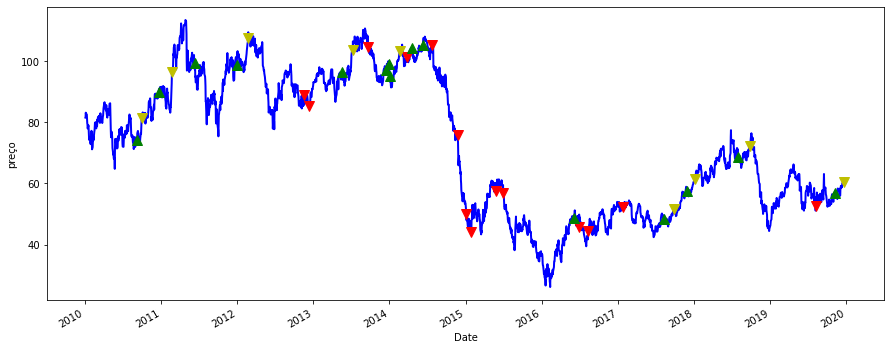

In [14]:
fig = plt.figure()

plt1 = fig.add_subplot(111,  ylabel='preço')

msft_data['Value'].plot(ax=plt1, color='b', lw=2.)


# venda_protecao
plt1.plot(msft_data['Value'][venda_defesa], 'v', markersize=10, color='r')

# compra_oportunidade
plt1.plot(msft_data['Value'][compra_oportunidade], '^', markersize=10, color='g')

# venda_por_ganho_ok
plt1.plot(msft_data['Value'][venda_ganho_fixado], 'v', markersize=10, color='y')

# show
plt.show()

In [15]:
operacoes

[{'venda': 189, 'compra': 172, 'index': 1, 'tipo_venda': 'ganho'},
 {'venda': 289, 'compra': 245, 'index': 2, 'tipo_venda': 'ganho'},
 {'venda': 539, 'compra': 503, 'index': 4, 'tipo_venda': 'ganho'},
 {'venda': 885, 'tipo_venda': 'ganho', 'compra': 851, 'index': 5},
 {'venda': 1041, 'tipo_venda': 'ganho', 'compra': 1008, 'index': 8},
 {'venda': 1149, 'tipo_venda': 'protecao', 'compra': 1116, 'index': 10},
 {'venda': 1641, 'tipo_venda': 'protecao', 'compra': 1625, 'index': 11},
 {'venda': 1960, 'tipo_venda': 'ganho', 'compra': 1926, 'index': 12},
 {'venda': 2028, 'compra': 2004, 'index': 13, 'tipo_venda': 'ganho'},
 {'venda': 2212, 'compra': 2171, 'index': 14, 'tipo_venda': 'ganho'},
 {'venda': 2523, 'tipo_venda': 'ganho', 'compra': 2494, 'index': 15}]

In [16]:
prod = 1
for el in operacoes:
    print(msft_data['Value'][el['venda']]/msft_data['Value'][el['compra']])
    prod = prod*msft_data['Value'][el['venda']]/msft_data['Value'][el['compra']]

1.0967003367003367
1.0744740064566403
1.0871192957603966
1.0744625610136047
1.08471725877654
1.0013321914549433
0.9406448962826042
1.0634528224145035
1.071254355400697
1.0491279069767443
1.0598035776920378


In [17]:
prod

1.7813016232743817

In [193]:
list(filter(lambda person: person['name'] == 'Pam', people))

[{'index': 0, 'compra': 0, 'venda': -1},
 {'index': 0, 'compra': 0, 'venda': -1}]

In [208]:
msft_data['Adj_Close'][1]

27.003575966039275

In [212]:
status_op['compra'] = lul

TypeError: list indices must be integers or slices, not str

In [59]:
preco_venda = []
preco_compra = []
venda_total = 0
compra_total = 0
for el in venda:
    preco_venda.append(msft_data['Adj_Close'][el])
    venda_total = venda_total + msft_data['Adj_Close'][el]
for el in compra:
    preco_compra.append(msft_data['Adj_Close'][el])
    compra_total = compra_total + msft_data['Adj_Close'][el]